In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from growth.sweep.sweep import Sweep
from clones.validation.sweep import SweepBenchmark
%matplotlib inline

In [2]:
ls ../synthetic/

Sweep_181201_191409/     Sweep_181201_191516_new/ build_sweep.py
Sweep_181201_191516/     Sweep_181201_191521/


In [3]:
sweep_path = '../synthetic/Sweep_181201_191516_new'
sweep = Sweep.load(sweep_path)
benchmark = SweepBenchmark.load(sweep_path)

In [1702]:
batch_id, scale_id = 2, 0
batch_benchmark = benchmark.load_benchmark(batch_id, scale_id)

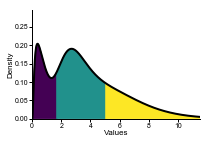

In [1703]:
batch_benchmark.classifier.plot_pdf()

In [1704]:
batch_benchmark.rule = 'proportional'
batch_benchmark.twolevel = True

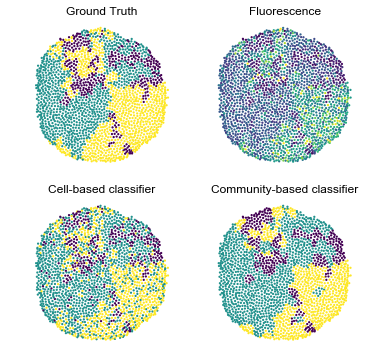

In [1705]:
simulation_benchmark = batch_benchmark.benchmark_simulation(1)
simulation_benchmark.show()

In [1706]:
"""
Katz centrality applied to directed edges weighted by max posterior.
"""

annotator = simulation_benchmark.annotator

# higher gamma means more influence from neighbors
gamma = 0.7

# build graph with directed edges weighted by posterior
columns = ['p0', 'p1', 'p2']
p0,p1,p2 = annotator.cell_classifier.evaluate_posterior(annotator.graph.df).T
annotator.graph.df['p0'] = p0
annotator.graph.df['p1'] = p1
annotator.graph.df['p2'] = p2

# add directed edges
posteriors_dict = {node: weights.to_dict() for node, weights in (gamma*annotator.graph.df.loc[annotator.graph.edges[:, 0]][['p0', 'p1', 'p2']]).iterrows()}
G = nx.DiGraph()
G.add_edges_from([(*edge, posteriors_dict[edge[0]]) for edge in annotator.graph.edges])

# add self edges
self_weights = (1-gamma) * annotator.graph.df.loc[list(G.nodes)][columns].values
G.add_weighted_edges_from([(node, node, dict(zip(columns, weights))) for node, weights in zip(list(G.nodes), self_weights)])


def katz_centrality(G, weight, normalized=True):    
    return np.vectorize(nx.katz_centrality(G, normalized=normalized, weight=weight).get)(G.nodes)

centralities = np.vstack((
    katz_centrality(G, weight='p0'),
    katz_centrality(G, weight='p1'),
    katz_centrality(G, weight='p2')))
    
katz_genotypes = centralities.argmax(axis=0)
graph_df = annotator.graph.df.loc[list(G.nodes)]
ground_truth_genotype = graph_df.ground.values
katz_scores = Scoring(ground_truth_genotype, katz_genotypes)
katz_scores.MAE

0.09505781055538969

Text(0.5,1,'Community Voting\n8.0% error')

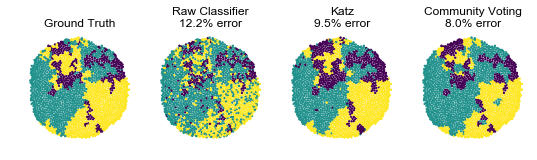

In [1707]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(9, 3))
for ax in (ax0, ax1, ax2, ax3):
    ax.set_aspect(1)
    ax.axis('off')

    
s = 2
ax0.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.ground, s=s)
ax0.set_title('Ground Truth')

ax1.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.simple_genotype, s=s)
ax1.set_title('Raw Classifier\n{:0.1%} error'.format(simulation_benchmark.simple_MAE))

ax2.scatter(*graph_df[['centroid_x', 'centroid_y']].values.T, c=katz_genotypes, s=s)
ax2.set_title('Katz\n{:0.1%} error'.format(katz_scores.MAE))

ax3.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.community_genotype, s=s)
ax3.set_title('Community Voting\n{:0.1%} error'.format(simulation_benchmark.community_MAE))

In [1481]:
"""
Katz centrality applied to directed edges weighted by max posterior.
"""

# build graph with directed edges weighted by posterior
annotator.graph.df['posterior'] = annotator.cell_classifier.evaluate_posterior(annotator.graph.df).max(axis=1)
G = nx.DiGraph()
weights = annotator.graph.df.loc[annotator.graph.edges[:, 0]][['posterior']].values.ravel()
G.add_weighted_edges_from([(*edge, x) for edge, x in zip(annotator.graph.edges, weights)])

node_posterior = annotator.cell_classifier.evaluate_posterior(annotator.graph.df)[list(G.nodes), :]
ground_truth_genotype = annotator.graph.df.loc[list(G.nodes)].ground.values

gamma = .3
adjacency = nx.to_numpy_array(G) * gamma
adjacency[np.identity(adjacency.shape[0]).astype(bool)] = (1-gamma) * node_posterior.max(axis=1) # add self edge
adjacency /= adjacency.sum(axis=0)

# max_alpha = 1/np.linalg.eigvals(adjacency).max()
alpha = .8
beta = 1.

n = np.array(adjacency).shape[0]
centrality = np.linalg.solve( np.eye(n,n) - (alpha * adjacency) , beta*node_posterior)
new_genotypes = centrality.argmax(axis=1)

new_scores = Scoring(ground_truth_genotype, new_genotypes)
new_scores.MAE

0.08597045916139022

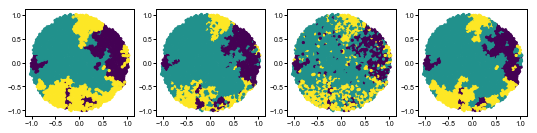

In [1403]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(9, 3))

ax0.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.ground, s=5)
ax0.set_aspect(1)

ax1.scatter(*graph_df[['centroid_x', 'centroid_y']].values.T, c=new_genotypes, s=5)
ax1.set_aspect(1)

ax2.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.simple_genotype, s=5)
ax2.set_aspect(1)

ax3.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.community_genotype, s=5)
ax3.set_aspect(1)

In [1456]:
"""
Katz centrality applied to undirected edges weighted by node similarity.
"""

# build undirected graph weighted by node similarity
G = nx.Graph()
G.add_weighted_edges_from(annotator.graph.build_links())
degree = np.vectorize(G.degree)(G.nodes)

graph_df = annotator.graph.df.loc[list(G.nodes)]

ground_truth_genotype = graph_df.ground.values
node_posterior = annotator.cell_classifier.evaluate_posterior(graph_df)
posterior = deepcopy(node_posterior.T)
previous_genotype = posterior.argmax(axis=0)

gamma = .5
adjacency = nx.to_numpy_array(G) * gamma
adjacency[np.identity(adjacency.shape[0]).astype(bool)] = (1-gamma) * node_posterior.max(axis=1) # add self edge
adjacency /= adjacency.sum(axis=0)

# max_alpha = 1/np.linalg.eigvals(adjacency).max()
alpha = 0.95
beta = 1.

n = np.array(adjacency).shape[0]
centrality = np.linalg.solve( np.eye(n,n) - (alpha * adjacency) , beta*posterior.T)

new_genotypes = centrality.argmax(axis=1)

new_scores = Scoring(ground_truth_genotype, new_genotypes)
new_scores.MAE

0.08230041635678421

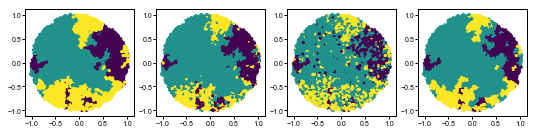

In [1454]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(9, 3))

ax0.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.ground, s=5)
ax0.set_aspect(1)

ax1.scatter(*graph_df[['centroid_x', 'centroid_y']].values.T, c=new_genotypes, s=5)
ax1.set_aspect(1)

ax2.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.simple_genotype, s=5)
ax2.set_aspect(1)

ax3.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.community_genotype, s=5)
ax3.set_aspect(1)

In [1479]:
"""
Katz centrality applied to undirected and unweighted edges.
"""

# build undirected graph weighted by node similarity
G = nx.Graph()
G.add_edges_from([edge[:2] for edge in annotator.graph.build_links()])
degree = np.vectorize(G.degree)(G.nodes)

graph_df = annotator.graph.df.loc[list(G.nodes)]

ground_truth_genotype = graph_df.ground.values
node_posterior = annotator.cell_classifier.evaluate_posterior(graph_df)
posterior = deepcopy(node_posterior.T)
previous_genotype = posterior.argmax(axis=0)

gamma = 1.
adjacency = nx.to_numpy_array(G) * gamma
#adjacency[np.identity(adjacency.shape[0]).astype(bool)] = (1-gamma) * node_posterior.max(axis=1) # add self edge
adjacency /= adjacency.sum(axis=1)

# max_alpha = 1/np.linalg.eigvals(adjacency).max()
alpha = 0.85
beta = 1.

n = np.array(adjacency).shape[0]
centrality = np.linalg.solve( np.eye(n,n) - (alpha * adjacency) , beta*posterior.T)

new_genotypes = centrality.argmax(axis=1)
new_scores = Scoring(ground_truth_genotype, new_genotypes)
new_scores.MAE

0.09128680510354771

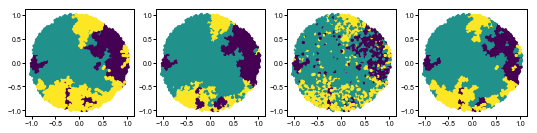

In [1480]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(9, 3))

ax0.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.ground, s=5)
ax0.set_aspect(1)

ax1.scatter(*graph_df[['centroid_x', 'centroid_y']].values.T, c=new_genotypes, s=5)
ax1.set_aspect(1)

ax2.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.simple_genotype, s=5)
ax2.set_aspect(1)

ax3.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.community_genotype, s=5)
ax3.set_aspect(1)

In [1434]:
eigenvalues.shape

(2225,)

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(M.T)
    ind = eigenvalues.argsort()
    # eigenvector of largest eigenvalue at ind[-1], normalized
    largest = np.array(eigenvectors[:, ind[-1]]).flatten().real
    norm = float(largest.sum())
    return dict(zip(G, map(float, largest / norm)))

In [1214]:
node_posterior = annotator.cell_classifier.evaluate_posterior(annotator.graph.df.loc[list(G.nodes)])
posterior = deepcopy(node_posterior.T)
adjacency = nx.to_numpy_array(G) 
adjacency /= adjacency.sum(axis=0)
previous_genotype = posterior.argmax(axis=0)

alpha = .2

delta = 1.
max_iters = 100
num_iters = 0
while delta > 0.00001 and num_iters < max_iters:
    num_iters += 1
    old_posterior = posterior
    posterior += (np.dot(posterior, adjacency)) - posterior/adjacency.sum(axis=0)
    delta = np.abs(posterior-old_posterior).sum()/old_posterior.sum()

f = np.vectorize(dict(zip(list(G.nodes), posterior.argmax(axis=0))).get)
new_genotypes = f(annotator.graph.df.index.values)

new_scores = Scoring(annotator.graph.df.ground.values, new_genotypes)
new_scores.MAE

0.20569980208042102

In [1205]:
posterior.sum(axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

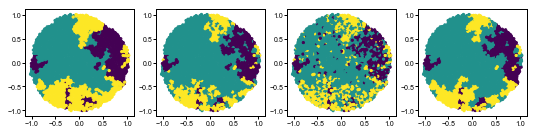

In [1209]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(9, 3))

ax0.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.ground, s=5)
ax0.set_aspect(1)

ax1.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=new_genotypes, s=5)
ax1.set_aspect(1)

ax2.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.simple_genotype, s=5)
ax2.set_aspect(1)

ax3.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.community_genotype, s=5)
ax3.set_aspect(1)

In [799]:
# katz
A = nx.adj_matrix(G, nodelist=nodelist, weight=weight).todense().T
    n = np.array(A).shape[0]
    centrality = np.linalg.solve( np.eye(n,n) - (alpha * A) , b)
    if normalized:
        norm = np.sign(sum(centrality)) * np.linalg.norm(centrality)
    else:
        norm = 1.0
    centrality = dict(zip(nodelist, map(float,centrality/norm)))
    return centrality

array([[5.39272434e+00, 6.54936958e+00, 1.19120876e+00, ...,
        1.16165247e+00, 6.55981985e-01, 1.06359875e+00],
       [4.42274238e-01, 3.20686839e-01, 5.39486270e+00, ...,
        6.43749485e+00, 3.45210835e+00, 4.94748479e+00],
       [6.45138843e-03, 9.64128572e-03, 3.70517920e-01, ...,
        2.28263483e-01, 9.75951061e-01, 1.75811476e-01]])

array([3.76121361, 4.31410068, 4.4708024 , ..., 4.24372333, 3.49021263,
       3.56996959])

In [725]:
degree.reshape(1, -1).shape

(1, 2225)

In [575]:
from copy import deepcopy

In [576]:
state = deepcopy(node_genotype).reshape(1, -1).astype(float)

In [664]:
state += np.dot(state, A)
state

array([[4.54342966e-05, 4.97663037e-05, 2.85154747e-11, ...,
        1.26669734e-10, 1.43574670e-10, 1.22754588e-10]])

In [666]:
state.max()

6.0603690369624866e-05

In [498]:
np.sum(A, axis=1)

array([6.        , 5.        , 4.20092546, ..., 4.16723578, 4.08693064,
       3.89302781])

array([-0.16666667, -0.2       , -0.2       , ..., -0.2       ,
       -0.16666667, -0.2       ])

In [411]:
a = 1

In [ ]:
annot

In [1531]:
annotator = simulation_benchmark.annotator

for genotype, posterior in enumerate(annotator.cell_classifier.evaluate_posterior(annotator.graph.df).T):
    annotator.graph.df[str(genotype)+'_posterior'] = posterior

# build graph
G = nx.DiGraph()
weights = annotator.graph.df.loc[annotator.graph.edges[:, 0]][['0_posterior', '1_posterior', '2_posterior']]
G.add_edges_from([(*edge, x.to_dict()) for edge, (_, x) in zip(annotator.graph.edges, weights.iterrows())])

# add self edges
node_posteriors = 3*annotator.graph.df.loc[np.array(list(G.nodes))][['0_posterior', '1_posterior', '2_posterior']]
#indegree = np.vectorize(G.in_degree)(node_posteriors.index)
G.add_edges_from([(node, node, row.to_dict()) for node, row in node_posteriors.iterrows()])

alpha, beta = 0.1, 1.
f0 = np.vectorize(nx.katz_centrality(G, alpha=alpha, beta=beta, weight='0_posterior').get)
f1 = np.vectorize(nx.katz_centrality(G, alpha=alpha, beta=beta, weight='1_posterior').get)
f2 = np.vectorize(nx.katz_centrality(G, alpha=alpha, beta=beta, weight='2_posterior').get)

new_genotype = np.vstack((f0(annotator.graph.nodes), f1(annotator.graph.nodes), f2(annotator.graph.nodes))).argmax(axis=0)
new_scores = Scoring(annotator.graph.df.ground.values, new_genotype)
new_scores.MAE

0.07435420740876625

In [1532]:
np.vstack((f0(annotator.graph.nodes), f1(annotator.graph.nodes), f2(annotator.graph.nodes)))

array([[0.01849752, 0.01746726, 0.01732258, ..., 0.0163141 , 0.01628095,
        0.01635442],
       [0.02688938, 0.02205707, 0.01984604, ..., 0.01578154, 0.01603195,
        0.01613263],
       [0.022217  , 0.01946697, 0.01924693, ..., 0.03145954, 0.02746264,
        0.0292527 ]])

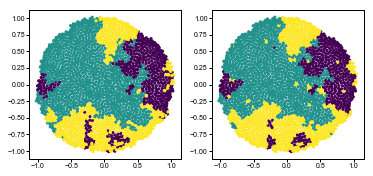

In [404]:
new_scores = Scoring(annotator.graph.df.ground.values, new_genotype)
new_scores.MAE

fig, (ax0, ax1) = plt.subplots(ncols=2)

ax0.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=annotator.graph.df.ground, s=5)
ax0.set_aspect(1)

ax1.scatter(*annotator.graph.df[['centroid_x', 'centroid_y']].values.T, c=new_genotype, s=5)
ax1.set_aspect(1)

In [345]:
nx.pagerank

In [341]:
node_posteriors

Int64Index([2057, 2062, 1384, 1306, 1383, 1300, 1274, 1402, 2065, 2059,
            ...
             100,   25,  605,  662,  661,  631,  810, 1390, 1693, 1337],
           dtype='int64', length=2225)

In [247]:
from clones.validation.scoring import Scoring

In [307]:
annotator = simulation_benchmark.annotator

for genotype, posterior in enumerate(annotator.cell_classifier.evaluate_posterior(annotator.graph.df).T):
    annotator.graph.df[str(genotype)+'_posterior'] = posterior

weights = annotator.graph.df.loc[annotator.graph.edges[:, 0]][['0_posterior', '1_posterior', '2_posterior']]
G = nx.DiGraph()
G.add_edges_from([(*edge, x.to_dict()) for edge, (_, x) in zip(annotator.graph.edges, weights.iterrows())])

incident_edges = np.vstack((
    nx.to_numpy_array(G, weight='0_posterior').sum(axis=0),
    nx.to_numpy_array(G, weight='1_posterior').sum(axis=0),
    nx.to_numpy_array(G, weight='2_posterior').sum(axis=0)))

node_posteriors = annotator.graph.df.loc[np.array(list(G.nodes))][['0_posterior', '1_posterior', '2_posterior']]

p = 0.
node_genotypes = ((1-p)*incident_edges + p*node_posteriors.values.T).argmax(axis=0)

f = np.vectorize(dict(zip(G.nodes, node_genotypes)).get)

new_scores = Scoring(annotator.graph.df.ground.values, f(annotator.graph.nodes))
new_scores.MAE

0.1292459207557952

In [229]:
weights

,0_posterior,1_posterior,2_posterior
264,0.130218,8.447971e-01,2.498506e-02
273,0.418610,5.810723e-01,3.174435e-04
283,0.088564,7.435173e-01,1.679182e-01
284,0.131771,8.445011e-01,2.372813e-02
1766,0.084337,7.039443e-01,2.117188e-01
1820,0.054590,2.734102e-01,6.719993e-01
1992,0.070449,5.242938e-01,4.052573e-01
263,0.070974,5.320323e-01,3.969941e-01
1437,1.000000,2.772862e-19,6.002554e-42
289,0.119691,8.437492e-01,3.656009e-02


In [32]:
import networkx as nx

In [ ]:
nx.eigenvector_centrality

In [534]:
fl.scale

array([1, 2, 4])

In [520]:
from growth.measure.fluorescence import Fluorescence

In [555]:

sigma = np.array([1, 2, 4]) # loc
mu = np.array([4, 2, 1]) # scale
fl = Fluorescence(mu=mu, sigma=sigma)

In [556]:
support = np.linspace(1, fl.saturation, 100)
pdfs = [fl.freeze_univariate(i).pdf(support) for i in range(3)]

In [557]:
Merge.jensen_shannon_distance(pdfs[0], pdfs[1])

0.0025221975780472493

In [558]:
Merge.jensen_shannon_distance(pdfs[1], pdfs[2])

0.013659506078500784

(0, 0.15)

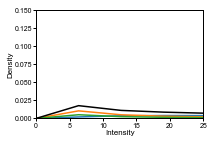

In [559]:
fl.show_pdf()
ax = plt.gca()
ax.set_xlim(0, 25)
ax.set_ylim(0, .15)

In [561]:
np.linspace(3, 10, 10-3+1)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [106]:
true_genotype_indices = simulation_benchmark.df.groupby('ground').indices

In [108]:
for genotype, ind in true_genotype_indices.items():
    ind

In [566]:
np.linspace(2, 10, 16)

array([ 2.        ,  2.53333333,  3.06666667,  3.6       ,  4.13333333,
        4.66666667,  5.2       ,  5.73333333,  6.26666667,  6.8       ,
        7.33333333,  7.86666667,  8.4       ,  8.93333333,  9.46666667,
       10.        ])

In [29]:
import networkx as nx
from clones.spatial.infomap import InfoMap

In [30]:
annotator = simulation_benchmark.annotator

In [34]:
infomap_obj = InfoMap(annotator.graph.build_links(), twolevel=True)
index_to_genotype = np.vectorize(annotator.graph.df.community_genotype.to_dict().get)
transclone_edges = annotator.graph.edges[(np.diff(index_to_genotype(annotator.graph.edges), axis=1)!=0).ravel()]
transcommunity_edges = infomap_obj(transclone_edges)
transcommunity_edges = np.unique(np.sort(transcommunity_edges, axis=1), axis=0)

In [35]:
community_to_indices = annotator.graph.df.groupby('community').indices
get_data = lambda community_id: annotator.graph.df.iloc[community_to_indices[community_id]]
evaluate_posterior = lambda community_id: annotator.cell_classifier.evaluate_posterior(get_data(community_id))

def evaluate_merger(communities):
    """ Evaluate posterior before and after merging pair of <communities>. """
    posterior_x = evaluate_posterior(communities[0])
    posterior_y = evaluate_posterior(communities[1])
    posterior_merged = np.vstack((posterior_x, posterior_y))
    max_posterior_separate = max(posterior_x.mean(axis=0).max(), posterior_y.mean(axis=0).max())
    max_posterior_merged = posterior_merged.mean(axis=0).max()
    merge = max_posterior_merged > max_posterior_separate
    return merge

In [36]:
sum(list(map(evaluate_merger, transcommunity_edges)))

0

In [458]:
test = np.random.random((10, 3))
test /= test.sum(axis=1).reshape(-1, 1)
 



print('current', test.mean(axis=0).argmax())
print('new', new)

current 2
new 2


In [389]:
def voter(posterior):
    confidence, genotypes = posterior.max(axis=1) , posterior.argmax(axis=1)   
    ind = np.argsort(genotypes)
    starts = np.searchsorted(genotypes[ind], np.arange(4))
    lengths = np.diff(starts)    
    return np.argmax([confidence[ind][slice(s, s+l)].sum() for s, l in zip(starts[:-1], lengths)])

current 1
new 0


In [375]:
starts

array([ 0,  2,  6, 10])

array([0.39943306, 0.37991861, 0.52630768, 0.56852259, 0.91814635,
       0.55345116, 0.46236173, 0.46127635, 0.4516243 , 0.40271046])

In [377]:
genotypes

array([0, 0, 1, 1, 1, 1, 2, 2, 2, 2])

slice(7, 10, None)

In [149]:
intercommunity_edges = np.unique(np.sort(community_edges[(np.diff(community_edges, axis=1)!=0).nonzero()[0]], axis=1), axis=0)

In [ ]:
[community_to_indices[community] for community in edge]

In [191]:
evaluate_merger(intercommunity_edges[0])

[array([0.20945352, 0.71454805, 0.07599843]),
 array([0.116708  , 0.6590875 , 0.22420451])]

In [192]:
intercommunity_edges

array([[  0,   1],
       [  0,   2],
       [  0,   3],
       [  0,   4],
       [  0,   5],
       [  0,   6],
       [  0,   7],
       [  1,   3],
       [  1,   7],
       [  1,   8],
       [  1,   9],
       [  1,  11],
       [  1,  13],
       [  1,  18],
       [  2,   3],
       [  2,   5],
       [  2,  14],
       [  2,  15],
       [  2, 126],
       [  2, 130],
       [  3,  13],
       [  3,  15],
       [  4,   5],
       [  4,   6],
       [  4, 111],
       [  4, 127],
       [  5, 126],
       [  5, 127],
       [  6,   7],
       [  6, 105],
       [  6, 106],
       [  6, 107],
       [  6, 111],
       [  6, 112],
       [  7,   8],
       [  7, 105],
       [  8,  18],
       [  8, 105],
       [  9,  10],
       [  9,  11],
       [  9,  12],
       [  9,  18],
       [ 10,  11],
       [ 10,  12],
       [ 10,  19],
       [ 11,  13],
       [ 12,  16],
       [ 12,  18],
       [ 12,  19],
       [ 13,  15],
       [ 13, 133],
       [ 14,  15],
       [ 14,

In [196]:
annotator.graph.df.groupby('community')['community_genotype'].mean()

community
0      1
1      1
2      1
3      1
4      1
5      1
6      1
7      2
8      1
9      1
10     1
11     2
12     1
13     1
14     2
15     2
16     2
17     2
18     1
19     1
20     1
21     1
22     1
23     1
24     2
25     1
26     1
27     1
28     1
29     1
      ..
220    0
221    0
222    0
223    2
224    0
225    0
226    0
227    2
228    0
229    0
230    0
231    0
232    0
233    0
234    0
235    0
236    0
237    0
238    0
239    0
240    0
241    2
242    2
243    0
244    0
245    0
246    0
247    0
248    0
249    0
Name: community_genotype, Length: 250, dtype: int64

In [ ]:
evaluate_posterior

,centroid_x,centroid_y,ground,fluorescence,simple_genotype,community,community_genotype
31,0.194498,-0.630649,1,2.187699,1,2,1
35,0.130123,-0.579730,1,3.083249,1,2,1
36,0.215909,-0.569158,1,4.494558,1,2,1
37,0.178519,-0.585730,1,2.641196,1,2,1
38,0.157734,-0.568908,1,4.452746,1,2,1
44,0.217839,-0.663129,1,3.267313,1,2,1
61,0.155692,-0.626482,1,1.844919,1,2,1
145,0.227725,-0.608616,1,3.272314,1,2,1
149,0.255546,-0.643100,1,3.089612,1,2,1
1562,0.196841,-0.519183,2,8.166420,2,2,1


In [158]:
communities = annotator.graph.df.groupby('community')

In [ ]:
community_to_genotype = communities.apply(voter).to_dict()

In [ ]:
posterior = cell_classifier.evaluate_posterior(x)

In [7]:
community_classifier = annotator.labeler

In [8]:
graph = annotator.graph

In [9]:
from clones.spatial.infomap import InfoMap

In [12]:
map_obj

In [ ]:
print("\nModules at depth 2:\n#node module")
for module in map_obj.infomap.iterModules(1):
    
    print("%d %d" % (node.physicalId, node.moduleIndex()))

In [82]:
parents, unique_ids, module_indices = {}, {}, {}
for unique_id, module in enumerate(map_obj.infomap.iterModules()):
    unique_ids[module.path()] = unique_id
    
    if len(module.path()) == 0:
        parent_id = -1
    else:
        parent_id = unique_ids[module.path()[:-1]]

    parents[unique_id] = parent_id
        
    if module.isLeafModule():
        module_indices[unique_id] = module.moduleIndex()

        
children = {unique_id: [] for unique_id in unique_ids.values()}
children[-1] = []
for child, parent in parents.items():
    children[parent].append(child)    
    
module_to_unique_id = {module_index: unique_id for unique_id, module_index in module_indices.items()}

In [85]:
module_to_parent_id = {module_id: parents[unique_id] for module_id, unique_id in module_to_unique_id.items()}

In [93]:
children[0]

[1, 118, 181]

In [88]:
module_to_parent_id

{0: 2,
 1: 2,
 2: 2,
 3: 2,
 4: 2,
 5: 2,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 2,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 22,
 19: 22,
 20: 22,
 21: 22,
 22: 22,
 23: 22,
 24: 22,
 25: 30,
 26: 30,
 27: 30,
 28: 30,
 29: 30,
 30: 30,
 31: 30,
 32: 30,
 33: 30,
 34: 30,
 35: 41,
 36: 41,
 37: 41,
 38: 41,
 39: 41,
 40: 41,
 41: 41,
 42: 41,
 43: 41,
 44: 41,
 45: 41,
 46: 41,
 47: 41,
 48: 41,
 49: 56,
 50: 56,
 51: 56,
 52: 56,
 53: 56,
 54: 56,
 55: 56,
 56: 64,
 57: 64,
 58: 64,
 59: 64,
 60: 64,
 61: 64,
 62: 64,
 63: 64,
 64: 64,
 65: 64,
 66: 75,
 67: 75,
 68: 75,
 69: 75,
 70: 75,
 71: 75,
 72: 75,
 73: 75,
 74: 75,
 75: 75,
 76: 75,
 77: 75,
 78: 75,
 79: 75,
 80: 75,
 81: 75,
 82: 75,
 83: 93,
 84: 93,
 85: 93,
 86: 93,
 87: 93,
 88: 93,
 89: 93,
 90: 93,
 91: 93,
 92: 93,
 93: 93,
 94: 93,
 95: 93,
 96: 93,
 97: 93,
 98: 109,
 99: 109,
 100: 109,
 101: 109,
 102: 109,
 103: 109,
 104: 109,
 105: 109,
 106: 119,
 107: 119,
 108: 119,
 109: 119,
 110: 119,
 111:

In [111]:
def recurse(parent):
    nodes = children[parent]    
    if len(nodes) < 1:
        return 1
    else:
        all_children_are_leaves = min([recurse(child) for child in nodes])
        if all_children_are_leaves:
            # MERGE CHILDREN            
            print(parent, nodes)
        
        # 
            
        return 0

In [36]:
from functools import reduce
from operator import add
reduce(add, ['a', 'b'])

'ab'

In [63]:
children = {}
for child, parent in parents.items():
    if parent not in children.keys():
        children[parent] = []
    children[parent].append(child)    

In [ ]:
for m

In [65]:
children

{(): [(), (0,), (1,)],
 (0,): [(0, 0),
  (0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 6),
  (0, 7),
  (0, 8),
  (0, 9),
  (0, 10)],
 (0, 0): [(0, 0, 0),
  (0, 0, 1),
  (0, 0, 2),
  (0, 0, 3),
  (0, 0, 4),
  (0, 0, 5),
  (0, 0, 6),
  (0, 0, 7),
  (0, 0, 8),
  (0, 0, 9),
  (0, 0, 10),
  (0, 0, 11),
  (0, 0, 12)],
 (0, 1): [(0, 1, 0),
  (0, 1, 1),
  (0, 1, 2),
  (0, 1, 3),
  (0, 1, 4),
  (0, 1, 5),
  (0, 1, 6),
  (0, 1, 7),
  (0, 1, 8),
  (0, 1, 9),
  (0, 1, 10),
  (0, 1, 11),
  (0, 1, 12),
  (0, 1, 13)],
 (0, 1, 4): [(0, 1, 4, 0), (0, 1, 4, 1), (0, 1, 4, 2), (0, 1, 4, 3)],
 (0, 2): [(0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (0, 2, 3),
  (0, 2, 4),
  (0, 2, 5),
  (0, 2, 6),
  (0, 2, 7),
  (0, 2, 8),
  (0, 2, 9),
  (0, 2, 10)],
 (0, 3): [(0, 3, 0),
  (0, 3, 1),
  (0, 3, 2),
  (0, 3, 3),
  (0, 3, 4),
  (0, 3, 5),
  (0, 3, 6),
  (0, 3, 7),
  (0, 3, 8),
  (0, 3, 9),
  (0, 3, 10),
  (0, 3, 11),
  (0, 3, 12),
  (0, 3, 13)],
 (0, 4): [(0, 4, 0),
  (0, 4, 1),
  (0, 4, 2),
  (0, 4, 3),
  (0,

In [61]:
module_paths = []

parents = {}
unique_module_id = 0
for module in map_obj.infomap.iterModules():
    
    
    parents[module.path()] = module.path()[:-1]
    
    if module.isLeafModule():
        print(module.moduleIndex(), module.path(), unique_module_id)
        
    unique_module_id += 1

0 (0, 0, 0) 3
1 (0, 0, 1) 4
2 (0, 0, 2) 5
3 (0, 0, 3) 6
4 (0, 0, 4) 7
5 (0, 0, 5) 8
6 (0, 0, 6) 9
7 (0, 0, 7) 10
8 (0, 0, 8) 11
9 (0, 0, 9) 12
10 (0, 0, 10) 13
11 (0, 0, 11) 14
12 (0, 0, 12) 15
13 (0, 1, 0) 17
14 (0, 1, 1) 18
15 (0, 1, 2) 19
16 (0, 1, 3) 20
17 (0, 1, 4, 0) 22
18 (0, 1, 4, 1) 23
19 (0, 1, 4, 2) 24
20 (0, 1, 4, 3) 25
21 (0, 1, 5) 26
22 (0, 1, 6) 27
23 (0, 1, 7) 28
24 (0, 1, 8) 29
25 (0, 1, 9) 30
26 (0, 1, 10) 31
27 (0, 1, 11) 32
28 (0, 1, 12) 33
29 (0, 1, 13) 34
30 (0, 2, 0) 36
31 (0, 2, 1) 37
32 (0, 2, 2) 38
33 (0, 2, 3) 39
34 (0, 2, 4) 40
35 (0, 2, 5) 41
36 (0, 2, 6) 42
37 (0, 2, 7) 43
38 (0, 2, 8) 44
39 (0, 2, 9) 45
40 (0, 2, 10) 46
41 (0, 3, 0) 48
42 (0, 3, 1) 49
43 (0, 3, 2) 50
44 (0, 3, 3) 51
45 (0, 3, 4) 52
46 (0, 3, 5) 53
47 (0, 3, 6) 54
48 (0, 3, 7) 55
49 (0, 3, 8) 56
50 (0, 3, 9) 57
51 (0, 3, 10) 58
52 (0, 3, 11) 59
53 (0, 3, 12) 60
54 (0, 3, 13) 61
55 (0, 4, 0) 63
56 (0, 4, 1) 64
57 (0, 4, 2) 65
58 (0, 4, 3) 66
59 (0, 4, 4) 67
60 (0, 4, 5) 68
61 (0, 4, 6) 69
6

In [42]:
paths = []
for module in map_obj.infomap.iterLeafModules():
    paths.append([module.moduleIndex(), module.path()])

In [45]:
pd.DataFrame(paths, columns=['ModuleID', 'Path'])

,ModuleID,Path
0,0,()
1,0,"(0, 0, 0)"
2,1,"(0, 0, 1)"
3,2,"(0, 0, 2)"
4,3,"(0, 0, 3)"
5,4,"(0, 0, 4)"
6,5,"(0, 0, 5)"
7,6,"(0, 0, 6)"
8,7,"(0, 0, 7)"
9,8,"(0, 0, 8)"


In [37]:

# Example
for node in map_obj.infomap.iterTree():
    if node.isLeaf:
        print("{} {}".format(node.path(), node.physicalId))

() 0
(0,) 0
(0, 0) 0
(0, 0, 0) 0
(0, 0, 0, 0) 0
(0, 0, 0, 1) 1
(0, 0, 0, 2) 10
(0, 0, 0, 3) 11
(0, 0, 0, 4) 12
(0, 0, 0, 5) 13
(0, 0, 0, 6) 14
(0, 0, 0, 7) 113
(0, 0, 0, 8) 2
(0, 0, 0, 9) 5
(0, 0, 0, 10) 6
(0, 0, 1) 0
(0, 0, 1, 0) 4
(0, 0, 1, 1) 7
(0, 0, 1, 2) 15
(0, 0, 1, 3) 61
(0, 0, 1, 4) 62
(0, 0, 1, 5) 117
(0, 0, 1, 6) 118
(0, 0, 1, 7) 119
(0, 0, 1, 8) 121
(0, 0, 2) 0
(0, 0, 2, 0) 16
(0, 0, 2, 1) 110
(0, 0, 2, 2) 111
(0, 0, 2, 3) 112
(0, 0, 2, 4) 96
(0, 0, 2, 5) 116
(0, 0, 2, 6) 120
(0, 0, 2, 7) 125
(0, 0, 2, 8) 77
(0, 0, 2, 9) 81
(0, 0, 3) 0
(0, 0, 3, 0) 33
(0, 0, 3, 1) 35
(0, 0, 3, 2) 3
(0, 0, 3, 3) 32
(0, 0, 3, 4) 53
(0, 0, 3, 5) 34
(0, 0, 3, 6) 38
(0, 0, 3, 7) 39
(0, 0, 3, 8) 40
(0, 0, 3, 9) 41
(0, 0, 3, 10) 52
(0, 0, 3, 11) 54
(0, 0, 4) 0
(0, 0, 4, 0) 93
(0, 0, 4, 1) 94
(0, 0, 4, 2) 95
(0, 0, 4, 3) 97
(0, 0, 4, 4) 99
(0, 0, 4, 5) 106
(0, 0, 4, 6) 108
(0, 0, 4, 7) 109
(0, 0, 5) 0
(0, 0, 5, 0) 107
(0, 0, 5, 1) 2104
(0, 0, 5, 2) 2105
(0, 0, 5, 3) 2106
(0, 0, 5, 4) 2107
(0, 0, 5,

(1, 1, 0, 1, 5) 1119
(1, 1, 0, 1, 6) 1120
(1, 1, 0, 1, 7) 1122
(1, 1, 0, 1, 8) 1340
(1, 1, 0, 1, 9) 1358
(1, 1, 0, 1, 10) 1121
(1, 1, 0, 2) 0
(1, 1, 0, 2, 0) 1110
(1, 1, 0, 2, 1) 1114
(1, 1, 0, 2, 2) 1109
(1, 1, 0, 2, 3) 1274
(1, 1, 0, 2, 4) 1277
(1, 1, 0, 2, 5) 1278
(1, 1, 0, 2, 6) 1336
(1, 1, 0, 2, 7) 1337
(1, 1, 0, 2, 8) 1338
(1, 1, 0, 2, 9) 1339
(1, 1, 0, 2, 10) 1341
(1, 1, 0, 2, 11) 1352
(1, 1, 0, 2, 12) 1353
(1, 1, 0, 2, 13) 1354
(1, 1, 0, 2, 14) 1355
(1, 1, 0, 2, 15) 1356
(1, 1, 0, 2, 16) 1357
(1, 1, 0, 3) 0
(1, 1, 0, 3, 0) 829
(1, 1, 0, 3, 1) 1199
(1, 1, 0, 3, 2) 1108
(1, 1, 0, 3, 3) 1123
(1, 1, 0, 3, 4) 1128
(1, 1, 0, 3, 5) 1129
(1, 1, 0, 3, 6) 1133
(1, 1, 0, 3, 7) 1188
(1, 1, 0, 3, 8) 1130
(1, 1, 0, 4) 0
(1, 1, 0, 4, 0) 1124
(1, 1, 0, 4, 1) 1198
(1, 1, 0, 4, 2) 1126
(1, 1, 0, 4, 3) 1125
(1, 1, 0, 4, 4) 1137
(1, 1, 0, 4, 5) 1138
(1, 1, 0, 4, 6) 1143
(1, 1, 0, 4, 7) 1144
(1, 1, 0, 4, 8) 1145
(1, 1, 0, 4, 9) 1187
(1, 1, 0, 5) 0
(1, 1, 0, 5, 0) 862
(1, 1, 0, 5, 1) 1183
(1, 1, 0, 

In [ ]:
for x in map_obj.infomap.consolidateModules():
    pass

In [70]:
print("Found %d top modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

# print("Writing top level modules to %s_level1.clu..." % name)
# tree.writeClu("%s_level1.clu" % name, 1)
# print("Writing second level modules to %s_level2.clu..." % name)
# tree.writeClu("%s_level2.clu" % name, 2)

# print("Writing tree to %s.tree..." % name)
# tree.writeHumanReadableTree("%s.tree" % name)

# print("\nModules at depth 1:\n#node module")
# for node in tree.leafIter(1):
# 	print("%d %d" % (node.physIndex, node.moduleIndex()))

# print("\nModules at depth 2:\n#node module")
# for node in tree.leafIter(2):
# 	print("%d %d" % (node.physIndex, node.moduleIndex()))

# print("\nModules at lowest level:\n#node module")
# for node in tree.leafIter(-1): # default -1
# 	print("%d %d" % (node.physIndex, node.moduleIndex()))

# print("\nModules at all levels:\n#node path childDegree")
# for node in tree.treeIter():
# 	if node.isLeaf:
# print("%d %s %d" % (node.physIndex, node.path(), node.childDegree()))

AttributeError: 'InfomapIterator' object has no attribute 'numTopModules'

In [13]:
branches = []
for module in map_obj.infomap.iterModules():
    if module.isLeafModule():
        branches.append(module.path())


In [18]:
for module in map_obj.infomap.iterModules():
    #print(module.moduleIndex())
    print(module.physicalId)
    
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [1]:
module

NameError: name 'module' is not defined

In [ ]:
class Parent:
    

In [ ]:
edges = self.build_links()
        community_detector = InfoMap(edges, **kwargs)
        self.community_labels = community_detector(self.nodes)

In [29]:
# find neighboring communities
label_community = np.vectorize(dict(enumerate(simulation_benchmark.df.community.values)).get)

In [30]:
label_community(annotator.graph.edges)

array([[112, 112],
       [115, 115],
       [108, 108],
       ...,
       [219, 219],
       [224, 219],
       [219, 224]])

In [ ]:
def voter(x):
                posterior = cell_classifier.evaluate_posterior(x)
                return posterior.mean(axis=0).argmax()

In [17]:
simulation_benchmark.df

,centroid_x,centroid_y,ground,fluorescence,simple_genotype,community,community_genotype
0,0.005203,-0.613773,1,2.217384,1,0,1
1,0.049206,-0.623072,1,2.419563,1,0,1
2,0.043215,-0.578854,1,4.821808,1,12,1
3,0.007155,-0.565074,1,3.677889,1,14,1
4,0.118149,-0.625145,1,3.117665,1,0,1
5,0.088932,-0.602255,1,2.591825,1,0,1
6,0.081660,-0.639340,1,2.615103,1,0,1
7,0.079315,-0.661363,1,2.884261,1,0,1
8,-0.040187,-0.591193,1,4.471313,1,16,1
9,-0.054415,-0.634184,1,4.199207,1,16,1


In [31]:
simulation_benchmark.annotator.cell_classifier